# Retirement Planner

---

## Environment Setup

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
# Set the random seed for resutls reproducibility (for testing purposes only)
np.random.seed(42)

---

## Portfolio Planner

In this activity, you will use the Alpaca API to grab historical data for a `60/40` portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv("api_keys.env")

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [4]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["SPY", "AGG"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

In [5]:
# Display sample data
df.head()

,AGG,SPY
,close,close
time,,
2019-01-02 00:00:00-05:00,106.585,249.89
2019-01-03 00:00:00-05:00,107.020,244.46
2019-01-04 00:00:00-05:00,106.695,252.41
2019-01-07 00:00:00-05:00,106.470,254.40
2019-01-08 00:00:00-05:00,106.420,256.65


---

## Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:

1. Calculate the daily returns for the SPY and AGG closing prices.

2. Calculate volatility for both the SPY and AGG closing prices.

3. Find the last day's closing price for both stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `100` iterations and generate at least `30` years of closing prices

**Hint:** There are `252` trading days per year, so the number of records to generate for each Monte Carlo run will be `252 days * 30 years`.

In [6]:
# Calculate the daily roi for the stocks
daily_returns = df.pct_change()
# Display sample data
daily_returns.head()

,AGG,SPY
,close,close
time,,
2019-01-02 00:00:00-05:00,NaN,NaN
2019-01-03 00:00:00-05:00,0.004081,-0.021730
2019-01-04 00:00:00-05:00,-0.003037,0.032521
2019-01-07 00:00:00-05:00,-0.002109,0.007884
2019-01-08 00:00:00-05:00,-0.000470,0.008844


In [7]:
# Compute daily volatility
std_dev_daily_return_agg = daily_returns.std()['AGG']['close']
std_dev_daily_return_spy = daily_returns.std()['SPY']['close']
std_dev_daily_return_spy

0.007820053413439366

In [8]:
# Compute avg daily return
avg_daily_return_agg = daily_returns.mean()['AGG']['close']
avg_daily_return_spy = daily_returns.mean()['SPY']['close']
avg_daily_return_spy

0.0010401250682146959

In [9]:
# Save the last day's closing price
agg_last_price = df['AGG']['close'][-1]
spy_last_price = df['SPY']['close'][-1]

In [10]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()

simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

for n in range(number_simulations):

    simulated_agg_prices = [agg_last_price]
    simulated_spy_prices = [spy_last_price]
    
    for i in range(number_records):
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        
        simulated_agg_prices.append(simulated_agg_price)
        simulated_spy_prices.append(simulated_spy_price)  
        
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)
    
    simulated_daily_returns = simulated_price_df.pct_change()
    
    weights = [0.4, 0.6]
    
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

portfolio_cumulative_returns.tail()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
7556,192.198632,173.061915,175.536542,137.184495,174.087276,406.898297,103.715503,207.335040,179.851038,154.485316,...,205.794078,209.597094,201.019313,150.405526,211.474529,419.025393,175.585603,465.203342,135.029922,207.278177
7557,191.796295,171.335698,175.073322,137.168852,174.462336,406.829966,103.095585,209.131281,179.936157,153.301078,...,205.522019,208.967028,201.668852,149.199635,211.588511,421.932597,175.990087,466.851578,135.447343,206.876247
7558,191.217898,171.137531,175.864455,137.377557,173.873490,408.572982,103.151109,209.957651,180.769205,153.380322,...,205.679462,209.612623,202.344679,148.768826,212.614164,422.012395,176.024377,463.429554,134.469736,207.289917
7559,190.859975,171.029260,176.121496,137.739761,175.432388,406.560889,102.902693,209.654533,179.742836,153.250418,...,206.056113,210.666825,201.151747,148.821403,213.780900,421.115650,176.285521,462.220129,133.666973,206.401943
7560,192.769939,171.963857,177.992293,138.460439,175.622694,406.595515,102.234885,209.318807,178.367586,153.115371,...,206.850892,209.781981,200.644529,149.216748,214.329392,421.158099,176.158309,459.010501,134.125079,207.485372


In [11]:
# Run the Monte Carlo Simulation


In [12]:
# Check that the simulation ran successfully


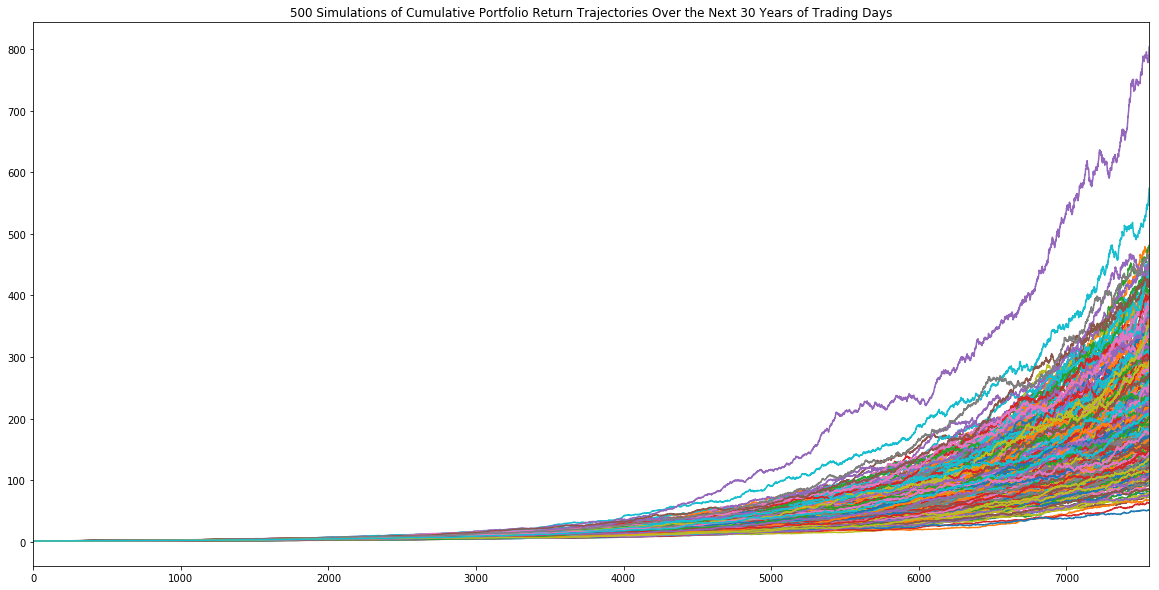

In [13]:
# Visualize the Simulation
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 30 Years of Trading Days"
portfolio_cumulative_returns.plot(legend=None, title=plot_title, figsize = [20,10])

In [14]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
twentyyr_ending_cumulative_returns = portfolio_cumulative_returns.iloc[20*252, :]
twentyyr_ending_cumulative_returns.head()

0    33.575023
1    31.031691
2    27.914190
3    24.841554
4    47.136645
Name: 5040, dtype: float64

In [15]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

0    192.769939
1    171.963857
2    177.992293
3    138.460439
4    175.622694
Name: 7560, dtype: float64

In [16]:
# Display the 90% confidence interval for the ending returns
#twentyyr_ending_cumulative_returns.value_counts(bins=10) / len(twentyyr_ending_cumulative_returns)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ninety_confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])
ninety_confidence_interval

0.05    102.825245
0.95    379.342101
Name: 7560, dtype: float64

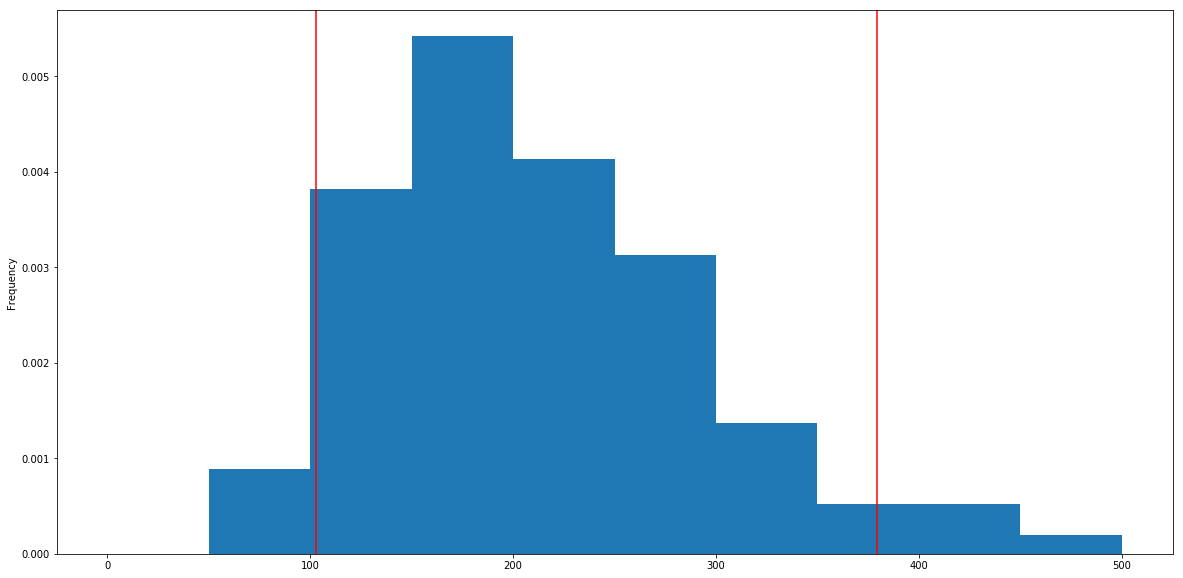

In [17]:
# Visualize the distribution of the ending returns
ending_cumulative_returns.plot(density=True, kind='hist', bins=[0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500], figsize = [20,10])
plt.axvline(ninety_confidence_interval.iloc[0], color='r')
plt.axvline(ninety_confidence_interval.iloc[1], color='r')

---

## Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at `30` years for the `10th`, `50th`, and `90th` percentiles?

2. Given an initial investment of `$20,000`, what is the expected return in dollars at the `10th`, `50th`, and `90th` percentiles?

3. Given the current projected annual income from the Plaid analysis, will a `4%` withdrawal rate meet or exceed that value at the `10th` percentile? Note: This is basically determining if retirement income is equivalent to current income.

4. How would a `50%` increase in the initial investment amount affect the `4%` retirement withdrawal? In other words, what happens if the initial investment had been bigger?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [18]:
# Compute cumulative returns
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]

thirtyyr_cumreturn_tenthquantile = ending_cumulative_returns.quantile(.1)
thirtyyr_cumreturn_fiftiethquantile = ending_cumulative_returns.quantile(.5)
thirtyyr_cumreturn_ninetiethquantile = ending_cumulative_returns.quantile(.9)
print(f"10th percentile: {thirtyyr_cumreturn_tenthquantile}")
print(f"50th percentile: {thirtyyr_cumreturn_fiftiethquantile}")
print(f"90th percentile: {thirtyyr_cumreturn_ninetiethquantile}")

10th percentile: 119.02985783731046
50th percentile: 199.0899699441323
90th percentile: 320.54983094157365


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [19]:
# Set initial investment
initial_investment = 20000
# Compute expected portfolio return
proj_thirty_tenthquartile = initial_investment * thirtyyr_cumreturn_tenthquantile
proj_thirty_fiftiethquartile = initial_investment * thirtyyr_cumreturn_fiftiethquantile
proj_thirty_ninetiethquartile = initial_investment * thirtyyr_cumreturn_ninetiethquantile
print("Projected return scenarios of a $20k initial investment over 30 years")
print(f"10th percentile: {proj_thirty_tenthquartile}")
print(f"50th percentile:: {proj_thirty_fiftiethquartile}")
print(f"90th percentile: {proj_thirty_ninetiethquartile}")

Projected return scenarios of a $20k initial investment over 30 years
10th percentile: 2380597.156746209
50th percentile:: 3981799.3988826456
90th percentile: 6410996.6188314725


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [20]:
# Set Plaid's projected income
proj_annual_income = 7389
# Calculate the 4% withdrawal for the ending return as retirement income
withdrawal_rate = .04
four_percent_wd_amt = round(proj_thirty_tenthquartile*withdrawal_rate,2)

In [21]:
# Determine if the retirement income meets or exceeds the current projected income
if four_percent_wd_amt >= proj_annual_income:
    print(f"You will have ${four_percent_wd_amt} in retirement income, which is sufficient")
else:
    print(f"You will have ${four_precent_wd_amt} in retirement income, which is insufficient")

You will have $95223.89 in retirement income, which is sufficient


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [22]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount
initial_investment_r = initial_investment*1.5 
proj_thirty_tenthquartile_r = initial_investment_r * thirtyyr_cumreturn_tenthquantile
four_percent_wd_amt_r = round(proj_thirty_tenthquartile_r*withdrawal_rate,2)

In [23]:
if four_percent_wd_amt_r >= proj_annual_income:
    print(f"You will have ${four_percent_wd_amt_r} in retirement income, which is sufficient")
else:
    print(f"You will have ${four_precent_wd_amt_r} in retirement income, which is insufficient")

You will have $142835.83 in retirement income, which is sufficient


In [24]:
# Scratch work
initial_investment = 20000
ending_balance = proj_thirty_tenthquartile
years = 30

def calculate_compound_growth_rate(initial_investment, ending_balance, years):
    growth_rate = (ending_balance / initial_investment)**(1/years) - 1
    return growth_rate

thirty_year_growth_tenth = calculate_compound_growth_rate(initial_investment, ending_balance, years)
round(thirty_year_growth_tenth,2)

0.17

### Optional Challenge

Use the Monte Carlo data and calculate the cumulative returns at the `5%`, `50%`, and `95%` quartiles and plot this data as a line chart to see how the cumulative returns change over the life of the investment.

In this section, you need to calculate and plot the cumulative returns for the median and `90%` confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [25]:
# Compute projected returns

# Display sample data


In [26]:
# Plot the cumulative returns over time


In [27]:
# Compute portfolio performance over time

# Plot projected performance over time
